In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2


In [3]:
DATASET = "aerial"

In [4]:
BASE_DIR = f"/home/vblot/multiaccurate_cp/data/{DATASET}"
MODELS_PATH = f"/home/vblot/multiaccurate_cp/data/{DATASET}/03_model_weights/resnet"
MODEL_NAME = "20240322_1039"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
config

{'mean_RGB_values_path': 'data/01_raw_images/rgb_means.npy',
 'ml_data_dir': 'data/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/03_model_weights/resnet',
 'probas_dir': 'data/04_predictions'}

In [7]:
IMG_SIZE = 64
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [8]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [9]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [10]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


0it [00:00, ?it/s]

1it [00:00,  1.21it/s]

34it [00:00, 49.75it/s]

97it [00:01, 150.62it/s]

159it [00:01, 243.52it/s]

220it [00:01, 323.43it/s]

281it [00:01, 391.75it/s]

343it [00:01, 448.52it/s]

404it [00:01, 491.46it/s]

466it [00:01, 524.68it/s]

527it [00:01, 548.10it/s]

588it [00:01, 564.79it/s]

650it [00:01, 579.37it/s]

711it [00:02, 587.58it/s]

776it [00:02, 603.38it/s]

839it [00:02, 608.94it/s]

901it [00:02, 609.50it/s]

963it [00:02, 612.22it/s]

1025it [00:02, 614.13it/s]

1089it [00:02, 620.45it/s]

1153it [00:02, 624.45it/s]

1217it [00:02, 626.40it/s]

1280it [00:02, 623.09it/s]

1343it [00:03, 620.47it/s]

1406it [00:03, 620.88it/s]

1469it [00:03, 622.83it/s]

1500it [00:03, 454.93it/s]

In [11]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

0it [00:00, ?it/s]

62it [00:00, 611.18it/s]

124it [00:00, 613.24it/s]

186it [00:00, 611.30it/s]

248it [00:00, 611.46it/s]

310it [00:00, 612.00it/s]

372it [00:00, 611.04it/s]

434it [00:00, 605.19it/s]

495it [00:00, 605.70it/s]

556it [00:00, 603.52it/s]

618it [00:01, 605.65it/s]

679it [00:01, 600.25it/s]

740it [00:01, 598.30it/s]

800it [00:01, 596.45it/s]

860it [00:01, 596.63it/s]

920it [00:01, 594.64it/s]

980it [00:01, 594.14it/s]

1040it [00:01, 594.82it/s]

1101it [00:01, 597.78it/s]

1162it [00:01, 599.00it/s]

1223it [00:02, 601.04it/s]

1284it [00:02, 600.34it/s]

1345it [00:02, 600.80it/s]

1406it [00:02, 599.97it/s]

1467it [00:02, 600.42it/s]

1528it [00:02, 599.06it/s]

1588it [00:02, 596.36it/s]

1648it [00:02, 597.18it/s]

1708it [00:02, 597.73it/s]

1769it [00:02, 598.87it/s]

1832it [00:03, 606.54it/s]

1894it [00:03, 609.83it/s]

1956it [00:03, 612.19it/s]

2018it [00:03, 611.02it/s]

2080it [00:03, 611.58it/s]

2142it [00:03, 610.59it/s]

2204it [00:03, 609.84it/s]

2267it [00:03, 613.25it/s]

2300it [00:03, 603.92it/s]

In [12]:
all_pred_probas = np.concatenate([cal_pred_probas, test_pred_probas])
all_res_emb = np.concatenate([cal_res_emb, test_res_emb])
all_labels = np.concatenate([cal_labels, test_labels])

In [13]:
all_pred_probas.shape

(3800, 64, 64)

In [14]:
ALPHA = .1

In [15]:
recalls = []
precisions = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]

    index_not_empy = np.where(temp_cal_labels.sum(axis=(1, 2)) > 0)[0]
    temp_cal_labels = temp_cal_labels[index_not_empy]
    temp_cal_res_emb = temp_cal_res_emb[index_not_empy]
    temp_cal_pred_probas = temp_cal_pred_probas[index_not_empy]

    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    print(temp_cal_pred_probas.shape, temp_test_pred_probas.shape)

    n = len(temp_cal_pred_probas)

    result = minimize(
        J, np.random.uniform(0, 1, EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, n), jac=J_prime,
        options={"disp": False, "maxiter": 10000}
    )

    ths = np.maximum((temp_test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
    y_pred_test_th = (temp_test_pred_probas >= ths).astype(int)
    recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
    precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall_test))
    precisions.append(np.nanmean(precision_test))
    print(np.nanmean(recall_test))

    


  0%|                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

(1574, 64, 64) (1900, 64, 64)


/tmp/ipykernel_1321223/56335789.py:33: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1321223/56335789.py:34: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
  1%|█▊                                                                                                                                                                                | 1/100 [00:49<1:21:38, 49.48s/it]

0.882426216152026
(1561, 64, 64) (1900, 64, 64)


  2%|███▌                                                                                                                                                                              | 2/100 [01:36<1:18:23, 48.00s/it]

0.8790158160740253
(1578, 64, 64) (1900, 64, 64)


  3%|█████▎                                                                                                                                                                            | 3/100 [02:36<1:26:29, 53.50s/it]

0.876484045501326
(1577, 64, 64) (1900, 64, 64)


  4%|███████                                                                                                                                                                           | 4/100 [03:36<1:30:00, 56.25s/it]

0.8895988233632525
(1554, 64, 64) (1900, 64, 64)


  5%|████████▉                                                                                                                                                                         | 5/100 [04:40<1:33:21, 58.97s/it]

0.8787563724493141
(1578, 64, 64) (1900, 64, 64)


  6%|██████████▋                                                                                                                                                                       | 6/100 [06:07<1:47:15, 68.47s/it]

0.8845052224670513
(1542, 64, 64) (1900, 64, 64)


  7%|████████████▍                                                                                                                                                                     | 7/100 [07:05<1:40:40, 64.95s/it]

0.886499703977083
(1569, 64, 64) (1900, 64, 64)


  8%|██████████████▏                                                                                                                                                                   | 8/100 [07:42<1:25:53, 56.02s/it]

0.8914602651992308
(1565, 64, 64) (1900, 64, 64)


  9%|████████████████                                                                                                                                                                  | 9/100 [08:43<1:27:19, 57.58s/it]

0.8720840181095939
(1569, 64, 64) (1900, 64, 64)


 10%|█████████████████▋                                                                                                                                                               | 10/100 [09:26<1:19:35, 53.06s/it]

0.8826455563694764
(1568, 64, 64) (1900, 64, 64)


 11%|███████████████████▍                                                                                                                                                             | 11/100 [10:39<1:27:55, 59.27s/it]

0.8735047264626288
(1558, 64, 64) (1900, 64, 64)


 12%|█████████████████████▏                                                                                                                                                           | 12/100 [11:55<1:34:14, 64.26s/it]

0.8869166363406501
(1571, 64, 64) (1900, 64, 64)


 13%|███████████████████████                                                                                                                                                          | 13/100 [13:07<1:36:49, 66.77s/it]

0.8786530879362086
(1566, 64, 64) (1900, 64, 64)


 14%|████████████████████████▊                                                                                                                                                        | 14/100 [14:20<1:38:10, 68.50s/it]

0.8796757162159649
(1538, 64, 64) (1900, 64, 64)


 15%|██████████████████████████▌                                                                                                                                                      | 15/100 [15:31<1:38:01, 69.19s/it]

0.888819338434068
(1551, 64, 64) (1900, 64, 64)


 16%|████████████████████████████▎                                                                                                                                                    | 16/100 [16:13<1:25:43, 61.23s/it]

0.8807562322446265
(1557, 64, 64) (1900, 64, 64)


 17%|██████████████████████████████                                                                                                                                                   | 17/100 [17:03<1:20:01, 57.85s/it]

0.881620479177072
(1575, 64, 64) (1900, 64, 64)


 18%|███████████████████████████████▊                                                                                                                                                 | 18/100 [17:48<1:13:38, 53.88s/it]

0.8912347504917031
(1563, 64, 64) (1900, 64, 64)


 19%|█████████████████████████████████▋                                                                                                                                               | 19/100 [18:50<1:15:52, 56.21s/it]

0.88386062439459
(1573, 64, 64) (1900, 64, 64)


 20%|███████████████████████████████████▍                                                                                                                                             | 20/100 [19:32<1:09:21, 52.02s/it]

0.8938154987050321
(1540, 64, 64) (1900, 64, 64)


 21%|█████████████████████████████████████▏                                                                                                                                           | 21/100 [20:28<1:10:16, 53.38s/it]

0.8829918399442718
(1569, 64, 64) (1900, 64, 64)


 22%|██████████████████████████████████████▉                                                                                                                                          | 22/100 [21:15<1:06:52, 51.45s/it]

0.8851143818939416
(1577, 64, 64) (1900, 64, 64)


 23%|█████████████████████████████████████████▏                                                                                                                                         | 23/100 [21:43<56:58, 44.39s/it]

0.8901724443020185
(1554, 64, 64) (1900, 64, 64)


 24%|██████████████████████████████████████████▍                                                                                                                                      | 24/100 [22:44<1:02:27, 49.31s/it]

0.8743741871600418
(1574, 64, 64) (1900, 64, 64)


 25%|████████████████████████████████████████████▎                                                                                                                                    | 25/100 [23:47<1:06:40, 53.34s/it]

0.8896660001220889
(1558, 64, 64) (1900, 64, 64)


 26%|██████████████████████████████████████████████                                                                                                                                   | 26/100 [25:08<1:15:59, 61.61s/it]

0.8834245524079944
(1571, 64, 64) (1900, 64, 64)


 27%|███████████████████████████████████████████████▊                                                                                                                                 | 27/100 [26:43<1:27:23, 71.82s/it]

0.8876160531070677
(1578, 64, 64) (1900, 64, 64)


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 28/100 [27:27<1:16:11, 63.50s/it]

0.8966522429015106
(1547, 64, 64) (1900, 64, 64)


 29%|███████████████████████████████████████████████████▎                                                                                                                             | 29/100 [28:29<1:14:23, 62.87s/it]

0.8832712283744969
(1560, 64, 64) (1900, 64, 64)


 30%|█████████████████████████████████████████████████████                                                                                                                            | 30/100 [29:19<1:08:56, 59.09s/it]

0.8836809418552362
(1550, 64, 64) (1900, 64, 64)


 31%|██████████████████████████████████████████████████████▊                                                                                                                          | 31/100 [30:11<1:05:22, 56.84s/it]

0.8802529595223694
(1575, 64, 64) (1900, 64, 64)


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 32/100 [30:58<1:01:11, 53.99s/it]

0.8852757963235668
(1557, 64, 64) (1900, 64, 64)


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 33/100 [31:59<1:02:35, 56.05s/it]

0.8743050665200842
(1579, 64, 64) (1900, 64, 64)


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 34/100 [33:13<1:07:41, 61.54s/it]

0.873656363605462
(1582, 64, 64) (1900, 64, 64)


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 35/100 [34:17<1:07:22, 62.19s/it]

0.88738036942185
(1562, 64, 64) (1900, 64, 64)


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 36/100 [35:31<1:10:16, 65.89s/it]

0.8833273298321692
(1579, 64, 64) (1900, 64, 64)


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 37/100 [36:39<1:09:46, 66.45s/it]

0.8809835717965951
(1542, 64, 64) (1900, 64, 64)


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 38/100 [37:31<1:04:00, 61.95s/it]

0.8778866392368706
(1558, 64, 64) (1900, 64, 64)


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 39/100 [38:35<1:03:38, 62.60s/it]

0.8856838603197918
(1557, 64, 64) (1900, 64, 64)


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 40/100 [39:36<1:02:20, 62.35s/it]

0.885499776888996
(1560, 64, 64) (1900, 64, 64)


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                        | 41/100 [40:50<1:04:36, 65.70s/it]

0.8804810751899745
(1568, 64, 64) (1900, 64, 64)


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                      | 42/100 [41:49<1:01:32, 63.66s/it]

0.8937965818908161
(1569, 64, 64) (1900, 64, 64)


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 43/100 [43:00<1:02:35, 65.89s/it]

0.8835387366605234
(1561, 64, 64) (1900, 64, 64)


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 44/100 [44:14<1:03:41, 68.24s/it]

0.8853171120127605
(1556, 64, 64) (1900, 64, 64)


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 45/100 [45:14<1:00:29, 66.00s/it]

0.8884576939074638
(1549, 64, 64) (1900, 64, 64)


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 46/100 [46:26<1:00:46, 67.52s/it]

0.8887802339610583
(1580, 64, 64) (1900, 64, 64)


 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 47/100 [47:28<58:18, 66.01s/it]

0.8879735032586672
(1566, 64, 64) (1900, 64, 64)


 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 48/100 [48:18<53:05, 61.27s/it]

0.8884752425991318
(1554, 64, 64) (1900, 64, 64)


 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 49/100 [49:22<52:44, 62.04s/it]

0.8856092122146876
(1548, 64, 64) (1900, 64, 64)


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 50/100 [50:41<55:58, 67.17s/it]

0.8840518306608195
(1552, 64, 64) (1900, 64, 64)


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 51/100 [52:18<1:02:01, 75.95s/it]

0.8869207096472891
(1555, 64, 64) (1900, 64, 64)


 52%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 52/100 [52:57<51:51, 64.83s/it]

0.8926448665048962
(1565, 64, 64) (1900, 64, 64)


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 53/100 [53:57<49:43, 63.49s/it]

0.8886344445850921
(1556, 64, 64) (1900, 64, 64)


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 54/100 [54:46<45:22, 59.18s/it]

0.8879267804434294
(1558, 64, 64) (1900, 64, 64)


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 55/100 [55:48<45:05, 60.13s/it]

0.8906903344393217
(1567, 64, 64) (1900, 64, 64)


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 56/100 [56:43<42:49, 58.41s/it]

0.8837847625596037
(1552, 64, 64) (1900, 64, 64)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 57/100 [57:45<42:45, 59.66s/it]

0.883089701383218
(1556, 64, 64) (1900, 64, 64)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 58/100 [58:16<35:39, 50.94s/it]

0.889783760180294
(1550, 64, 64) (1900, 64, 64)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 59/100 [59:33<40:06, 58.71s/it]

0.892081808998963
(1544, 64, 64) (1900, 64, 64)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 60/100 [1:00:19<36:42, 55.07s/it]

0.8850763663016421
(1562, 64, 64) (1900, 64, 64)


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 61/100 [1:01:22<37:13, 57.27s/it]

0.8794501462128916
(1556, 64, 64) (1900, 64, 64)


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 62/100 [1:02:36<39:32, 62.43s/it]

0.8869647081078655
(1575, 64, 64) (1900, 64, 64)


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 63/100 [1:03:32<37:20, 60.55s/it]

0.8875685905187755
(1538, 64, 64) (1900, 64, 64)


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 64/100 [1:04:34<36:26, 60.73s/it]

0.8873793792967308
(1551, 64, 64) (1900, 64, 64)


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 65/100 [1:05:40<36:23, 62.38s/it]

0.8828351413326418
(1565, 64, 64) (1900, 64, 64)


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 66/100 [1:06:40<34:55, 61.64s/it]

0.8811500031847141
(1563, 64, 64) (1900, 64, 64)


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 67/100 [1:07:43<34:13, 62.24s/it]

0.8759039835226489
(1564, 64, 64) (1900, 64, 64)


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 68/100 [1:08:13<27:59, 52.48s/it]

0.8882220755658754
(1574, 64, 64) (1900, 64, 64)


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 69/100 [1:09:23<29:52, 57.82s/it]

0.873707884987452
(1566, 64, 64) (1900, 64, 64)


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 70/100 [1:10:24<29:17, 58.57s/it]

0.8749820705437696
(1576, 64, 64) (1900, 64, 64)


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 71/100 [1:11:01<25:15, 52.27s/it]

0.8853187555374002
(1568, 64, 64) (1900, 64, 64)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 72/100 [1:12:03<25:43, 55.13s/it]

0.8878571270960145
(1558, 64, 64) (1900, 64, 64)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 73/100 [1:13:04<25:32, 56.74s/it]

0.8799665334736343
(1560, 64, 64) (1900, 64, 64)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 74/100 [1:14:14<26:22, 60.85s/it]

0.8857782376125536
(1566, 64, 64) (1900, 64, 64)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 75/100 [1:15:03<23:52, 57.31s/it]

0.8909646631476446
(1566, 64, 64) (1900, 64, 64)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 76/100 [1:16:14<24:34, 61.42s/it]

0.884020885544883
(1575, 64, 64) (1900, 64, 64)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 77/100 [1:18:16<30:29, 79.55s/it]

0.8782024068793906
(1556, 64, 64) (1900, 64, 64)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 78/100 [1:19:29<28:24, 77.49s/it]

0.8811744418341776
(1562, 64, 64) (1900, 64, 64)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 79/100 [1:20:30<25:26, 72.67s/it]

0.8852222395881305
(1552, 64, 64) (1900, 64, 64)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 80/100 [1:21:37<23:40, 71.03s/it]

0.883166914719828
(1569, 64, 64) (1900, 64, 64)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/100 [1:22:42<21:56, 69.28s/it]

0.8892283446160456
(1546, 64, 64) (1900, 64, 64)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 82/100 [1:23:29<18:45, 62.55s/it]

0.8885759718283799
(1551, 64, 64) (1900, 64, 64)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 83/100 [1:24:31<17:38, 62.28s/it]

0.8823081287463885
(1568, 64, 64) (1900, 64, 64)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 84/100 [1:25:35<16:44, 62.75s/it]

0.8799873522662919
(1574, 64, 64) (1900, 64, 64)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 85/100 [1:26:30<15:07, 60.50s/it]

0.8845297800113519
(1559, 64, 64) (1900, 64, 64)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 86/100 [1:27:13<12:51, 55.13s/it]

0.8820152283140849
(1562, 64, 64) (1900, 64, 64)


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 87/100 [1:28:27<13:10, 60.77s/it]

0.8881569514578151
(1580, 64, 64) (1900, 64, 64)


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 88/100 [1:28:57<10:20, 51.75s/it]

0.8895527690345444
(1557, 64, 64) (1900, 64, 64)


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 89/100 [1:30:11<10:41, 58.33s/it]

0.8869469432731291
(1570, 64, 64) (1900, 64, 64)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 90/100 [1:31:24<10:27, 62.80s/it]

0.8843499144053776
(1569, 64, 64) (1900, 64, 64)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 91/100 [1:32:24<09:18, 62.01s/it]

0.8836456789233552
(1566, 64, 64) (1900, 64, 64)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 92/100 [1:33:30<08:25, 63.15s/it]

0.8848674673276113
(1557, 64, 64) (1900, 64, 64)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 93/100 [1:34:28<07:11, 61.60s/it]

0.8806211925850642
(1535, 64, 64) (1900, 64, 64)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 94/100 [1:35:26<06:02, 60.48s/it]

0.892708566852473
(1557, 64, 64) (1900, 64, 64)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 95/100 [1:36:19<04:50, 58.15s/it]

0.8899554517234053
(1569, 64, 64) (1900, 64, 64)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 96/100 [1:37:17<03:53, 58.31s/it]

0.8790000408483122
(1541, 64, 64) (1900, 64, 64)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 97/100 [1:38:32<03:10, 63.34s/it]

0.8872458988111103
(1553, 64, 64) (1900, 64, 64)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 98/100 [1:38:53<01:41, 50.65s/it]

0.8925921937108386
(1556, 64, 64) (1900, 64, 64)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 99/100 [1:39:45<00:50, 50.83s/it]

0.882900133698198
(1589, 64, 64) (1900, 64, 64)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:40:44<00:00, 53.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:40:44<00:00, 60.44s/it]

0.8954878951086316


(array([ 6.,  3.,  7., 11., 20., 14., 21., 10.,  6.,  2.]),
 array([0.87208402, 0.87454084, 0.87699766, 0.87945449, 0.88191131,
        0.88436813, 0.88682495, 0.88928178, 0.8917386 , 0.89419542,
        0.89665224]),
 <BarContainer object of 10 artists>)

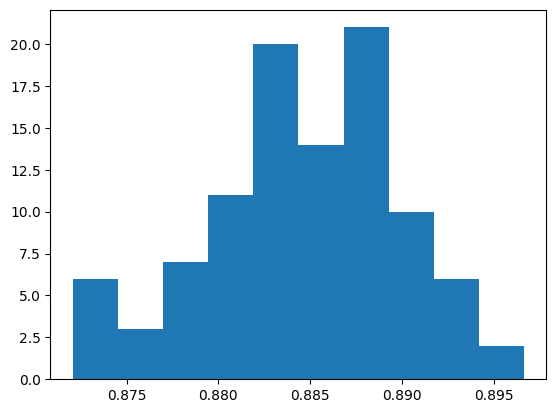

In [16]:
plt.hist(recalls)

In [17]:
np.mean(recalls)

0.8846517558525043